# 1. Model description

In [1]:
using ReachabilityAnalysis, BenchmarkTools, Plots

┌ Info: Precompiling ReachabilityAnalysis [1e97bd63-91d1-579d-8e8d-501d2b57c93f]
└ @ Base loading.jl:1260


In [2]:
# parameters of the model
const g = 9.81;           # gravity constant in m/s^2
const R = 0.1;            # radius of center mass in m
const l = 0.5;            # distance of motors to center mass in m
const Mrotor = 0.1;       # motor mass in kg
const M = 1.0;            # center mass in kg
const m = M + 4*Mrotor;   # total mass in kg
const mg = m*g;

# moments of inertia
const Jx = (2/5)*M*R^2 + 2*l^2*Mrotor;
const Jy = Jx;
const Jz = (2/5)*M*R^2 + 4*l^2*Mrotor;
const Cyzx = (Jy - Jz)/Jx;
const Czxy = (Jz - Jx)/Jy;
const Cxyz = 0.0; #(Jx - Jy)/Jz

# considering the control parameters as *parameters*
const u₁ = 1.0;
const u₂ = 0.0;
const u₃ = 0.0;

In [3]:
@taylorize function quadrotor!(dx, x, params, t)
    # unwrap the variables and the controllers; the last three are the controllers
    # x₁, x₂, x₃, x₄, x₅, x₆, x₇, x₈, x₉, x₁₀, x₁₁, x₁₂, u₁, u₂, u₃ = x
    x₁  = x[1]
    x₂  = x[2]
    x₃  = x[3]
    x₄  = x[4]
    x₅  = x[5]
    x₆  = x[6]
    x₇  = x[7]
    x₈  = x[8]
    x₉  = x[9]
    x₁₀ = x[10]
    x₁₁ = x[11]
    x₁₂ = x[12]

    # equations of the controllers
    F = (mg - 10*(x₃ - u₁)) + 3*x₆  # height control
    τϕ = -(x₇ - u₂) - x₁₀            # roll control
    τθ = -(x₈ - u₃) - x₁₁            # pitch control
    local τψ = 0.0                   # heading is uncontrolled
    #
    Tx = τϕ/Jx
    Ty = τθ/Jy
    Tz = τψ/Jz
    F_m = F/m

    # Some abbreviations
    sx7 = sin(x₇)
    cx7 = cos(x₇)
    sx8 = sin(x₈)
    cx8 = cos(x₈)
    sx9 = sin(x₉)
    cx9 = cos(x₉)
    #
    sx7sx9 = sx7*sx9
    sx7cx9 = sx7*cx9
    cx7sx9 = cx7*sx9
    cx7cx9 = cx7*cx9
    sx7cx8 = sx7*cx8
    cx7cx8 = cx7*cx8
    sx7_cx8 = sx7/cx8
    cx7_cx8 = cx7/cx8
    #
    x4cx8 = cx8*x₄
    #
    p11 = sx7_cx8*x₁₁
    p12 = cx7_cx8*x₁₂
    xdot9 = p11 + p12

    # differential equations for the quadrotor
    #
    dx[1] = (cx9*x4cx8 + (sx7cx9*sx8 - cx7sx9)*x₅) + (cx7cx9*sx8 + sx7sx9)*x₆
    dx[2] = (sx9*x4cx8 + (sx7sx9*sx8 + cx7cx9)*x₅) + (cx7sx9*sx8 - sx7cx9)*x₆
    dx[3] = (sx8*x₄ - sx7cx8*x₅) - cx7cx8*x₆
    dx[4] = (x₁₂*x₅ - x₁₁*x₆) - g*sx8
    dx[5] = (x₁₀*x₆ - x₁₂*x₄) + g*sx7cx8
    dx[6] = (x₁₁*x₄ - x₁₀*x₅) + (g*cx7cx8 - F_m)
    dx[7] = x₁₀ + sx8*xdot9
    dx[8] = cx7*x₁₁ - sx7*x₁₂
    dx[9] = xdot9
    dx[10] = Cyzx * (x₁₁ * x₁₂) + Tx
    dx[11] = Czxy * (x₁₀ * x₁₂) + Ty
    dx[12] = Cxyz * (x₁₀ * x₁₁) + Tz
    #
    return dx
end

# 2. Reachability settings

In [4]:
# initial conditions
Wpos = 0.4
Wvel = 0.4
X0c = zeros(12)
ΔX0 = [Wpos, Wpos, Wpos, Wvel, Wvel, Wvel, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
X0 = Hyperrectangle(X0c, ΔX0);

# 3. Results

In [20]:
prob = @ivp(x' = quadrotor!(x), dim: 12, x(0) ∈ X0);

sol = solve(prob, tspan=(0.0, 5.0), TMJets(abs_tol=1e-7, orderT=5, orderQ=1));
solz = overapproximate(sol, Zonotope)
@btime solve($prob, tspan=(0.0, 5.0), TMJets(abs_tol=1e-7, orderT=5, orderQ=1));

  2.003 s (40975063 allocations: 2.50 GiB)


The task is to change the height from 0 [m] to 1 [m] within 5 [s]. A goal region [0.98, 1.02] of the
height x3 has to be reached within 5 [s] and the height has to stay below 1.4 for all times. After
1 [s] the height should stay above 0.9 [m].

In [24]:
# x3 < 1.4 for all times
using LazySets: SingleEntryVector

v3 = SingleEntryVector(3, 12, 1.0)
@show ρ(v3, solz)
@assert ρ(v3, solz) < 1.4

ρ(v3, solz) = 1.3582571151221239


In [25]:
# check that the final state is in the goal region
@show ρ(v3, solz[end])
@show -ρ(-v3, solz[end])

ρ(v3, solz[end]) = 0.9983384155573501
-(ρ(-v3, solz[end])) = 0.9945928748059757


0.9945928748059757

In [94]:
# equivalent check
@assert set(project(solz[end], vars=(3))) ⊆ Interval(0.98, 1.02)

In [99]:
tf = tend(solz)
unsafe = HalfSpace(v3, 0.9) # unsafe: x3 <= 0.9
@assert all([isdisjoint(unsafe, set(R)) for R in solz(1.0 .. tf)])

In [88]:
# equivalent check
-ρ(-v3, Flowpipe(Vector(solz(1.0 .. tf)))) # should be > 0.9

0.9091207794101679

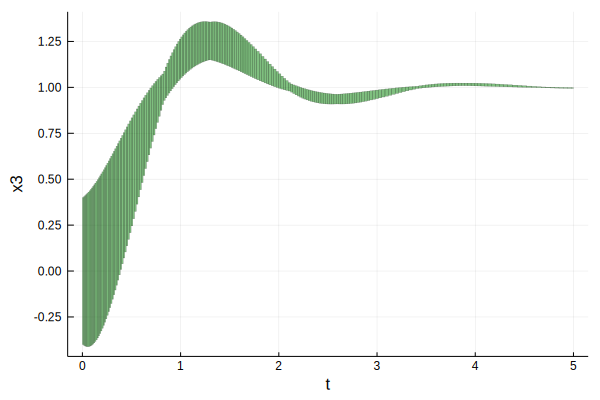

In [82]:
plot(solz, vars=(0, 3), color=:green, lw=0.3, xlab="t", ylab="x3")

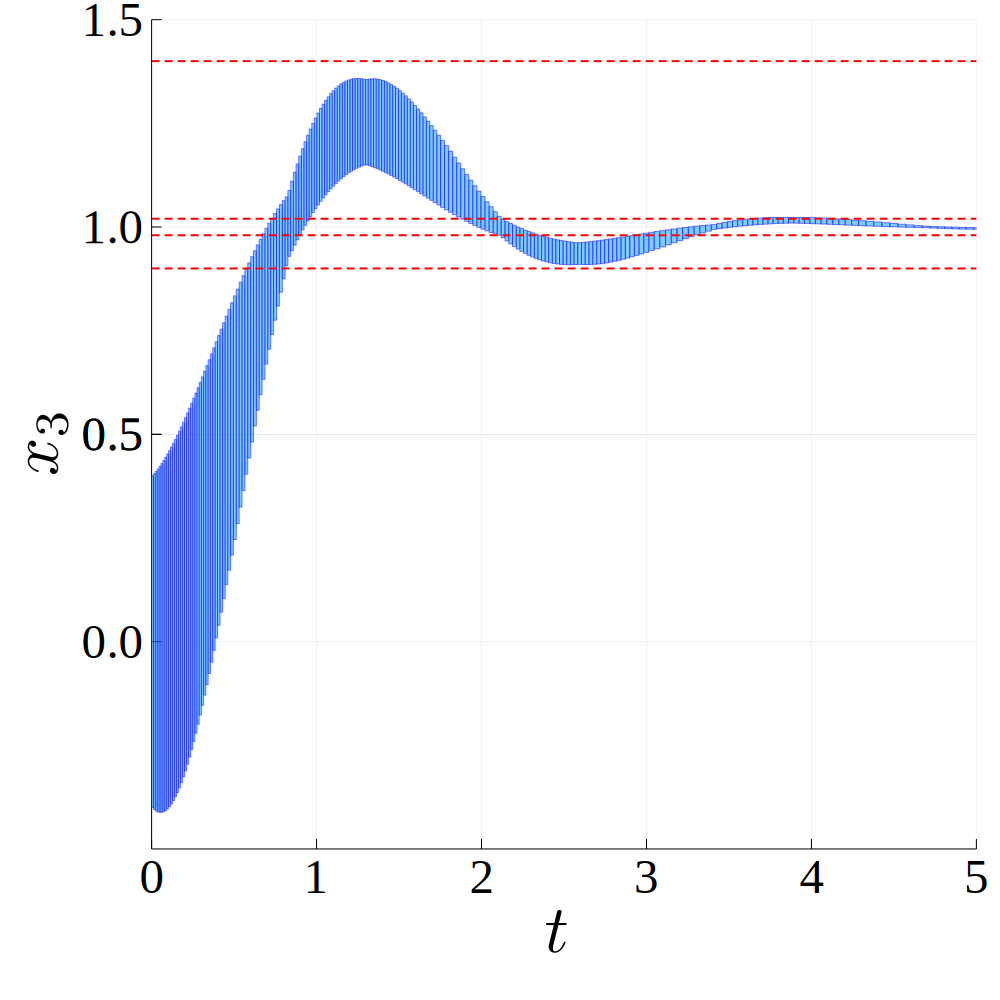

In [92]:
# publication-ready plot
using Plots.PlotMeasures, LaTeXStrings

plot(solz, vars=(0, 3),
     tickfont=font(30, "Times"), guidefontsize=45,
     xlab=L"t\raisebox{-0.5mm}{\textcolor{white}{.}}",
     ylab=L"x_{3}\raisebox{1mm}{\textcolor{white}{.}}",
     xtick=[0., 1, 2, 3, 4, 5], ytick=[0.5, 0., 0.5, 1.0, 1.5],
     xlims=(0., 5.), ylims=(-0.5, 1.5),
     bottom_margin=6mm, left_margin=6mm, right_margin=4mm, top_margin=3mm,
     size=(1000, 1000), linecolor="blue")

plot!(x->x, x->1.4, 0., 5., line=2, color="red", linestyle=:dash, legend=nothing)
plot!(x->x, x->0.98, 0., 5., line=2, color="red", linestyle=:dash, legend=nothing)
plot!(x->x, x->1.02, 0., 5., line=2, color="red", linestyle=:dash, legend=nothing)
plot!(x->x, x->0.9, 0., 5., line=2, color="red", linestyle=:dash, legend=nothing)

In [93]:
savefig("quadrotor.png")